In [1]:
# Restart the kernel
import os
current_dir ='../../../'
os.chdir(current_dir)

In [2]:
from src.codes.basic import *
from src.codes.utils import *

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM
from src.codes.prob_classes.base_class_heat_conduction import probdata

import src.codes.reductor.rom_class as rom_class
from src.codes.algorithms.ecsw import ecsw_red
from importlib import reload


### class for data (geometry, material property, mesh)

In [3]:
n_ref = np.array([40*10, 10*10], dtype=int)
w = np.array([ 0.4, 0.1])
L = np.sum(w)

# Create arrays of zeros and ones
zeros_array = np.zeros((1, n_ref[0]))
ones_array = np.ones((1, n_ref[1]))

# Concatenate along the second axis (axis=1)
mat_layout = np.concatenate((zeros_array, ones_array), axis=1)
src_layout = np.concatenate((zeros_array, ones_array), axis=1)

In [4]:
fdict = {}

tune = 1

cond_list = []
cond_list.append(lambda T,mu: 1.05*mu*tune + 2150/(T-73.15))
cond_list.append(lambda T,mu: mu*tune*7.51 + 2.09e-2*T - 1.45e-5*T**2 + 7.67e-9*T**3)
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append(lambda T,mu: -2150/(T-73.15)**2 )
dcond_list.append(lambda T,mu: 2.09e-2 - 2*1.45e-5*T + 3*7.67e-9*T**2)
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 35000.0 + 0.0*T)
qext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["qext"] = qext_list

dqext_list = []
dqext_list.append( lambda T,mu: 0.0 + 0.*T)
dqext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["dqext"] = dqext_list

In [5]:
bc = {}
bc['x_min']={'type':'refl','value':np.nan}
bc['x_max']={'type':'dirichlet','value':273.15+300.}   

In [6]:
print(mat_layout.flatten().shape[0])

500


### Simulate FOS

In [7]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []
K_mus = []
q_mus = []
# 


 Snap 0

 Snap 1

 Snap 2

 Snap 3

 Snap 4

 Snap 5

 Snap 6

 Snap 7

 Snap 8

 Snap 9

 Snap 10

 Snap 11

 Snap 12

 Snap 13

 Snap 14


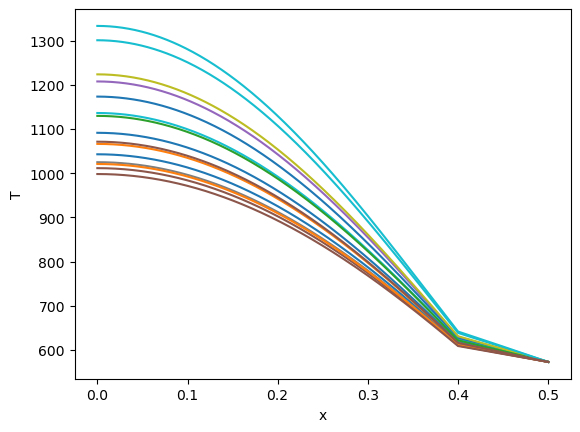

In [8]:
fig, ax = plt.subplots()

for i in range(N_snap):
    print(f"\n Snap {i}")
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, n_ref, L, param, pb_dim=1)
        FOS = FOS_FEM(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 273.15
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init)
    NL_solutions.append(NL_solution_p.flatten())
    K_mus.append(Ke)
    q_mus.append(rhs_e)
    plot1D(d.xi[0], NL_solution_p, ax=ax)

plt.show()


In [9]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(15, 501)

### ECSW Hyper-reduction


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

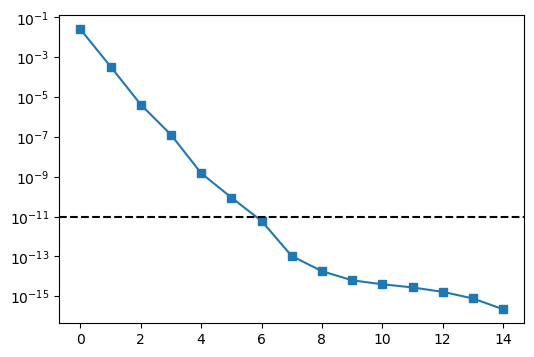

In [10]:
n_sel, U = svd_mode_selector(NL_solutions, tol_f=1e-11)
V_sel = U[:, :n_sel]

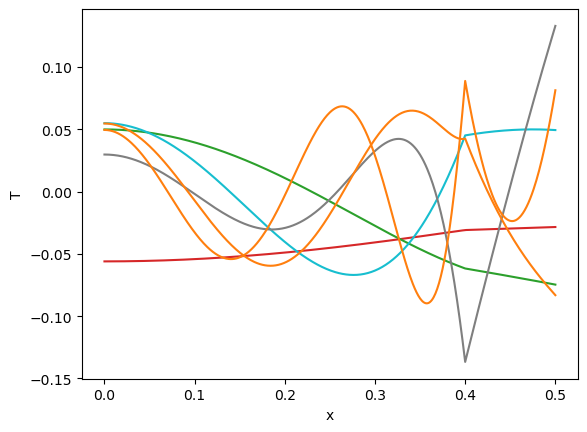

In [11]:
fig, ax = plt.subplots()

for i in range(n_sel):
    plot1D(d.xi[0],V_sel[:,i],ax=ax)

plt.show()


#### Step 2: ECSW

In [12]:
tic_h_setup_b = time.time()
tol = None
xi, residual = ecsw_red(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap, mask,NL_solutions,tol=tol)
toc_h_setup_b = time.time()

In [13]:
print(f"this is the residual from fnnls: {residual}")

this is the residual from fnnls: 1.1115026111866793e-12


In [14]:
colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

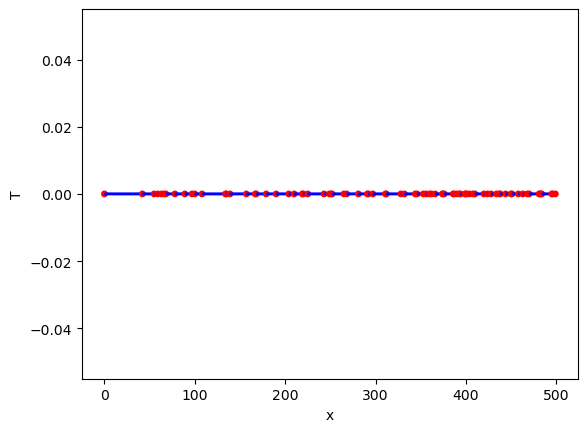

In [15]:
plot1D(np.arange(d.ncells[0]), np.zeros_like(xi), scattr=True, clr=colors, sz=sizes)

In [16]:
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 16.0%



### ROM Simulation

In [17]:
params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [18]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, n_ref, L, param_rom, pb_dim=1)
FOS_test = FOS_FEM(d_test,quad_deg)
ROM_h = rom_class.rom_ecsw(d_test, quad_deg)
ROM = rom_class.rom(d_test, quad_deg)

In [19]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 273.15
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [20]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

In [21]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,V_sel)
toc_rom_woh = time.time()

c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [22]:
# Time taken to simulate a ROM *with* hyper-reduction
tic_rom = time.time()
NL_solution_p_reduced = ROM_h.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

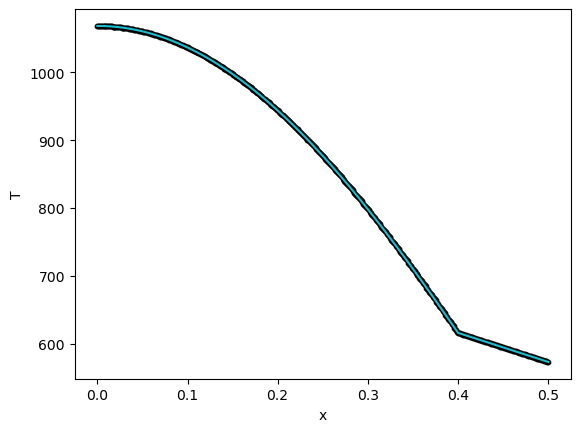

RMS_error is 2.0865098962987602e-08 %


In [23]:
sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)  #+pca.mean_.reshape(-1,1)

fig, ax = plt.subplots()

plot1D(d_test.xi[0], sol_red, ax=ax)
plot1D(d_test.xi[0], NL_solution_p_fos_test, ax=ax, scattr=True, clr='k', sz=10)

plt.show()

print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

In [24]:

print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")



ROM Error without hyperreduction is 2.0838578761020126e-08 %



#### Speedups

In [25]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [26]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:0.9377200290293553
speedup with hyperreduction:5.563990236519255
